In [2]:
import numpy as np
import pandas as pd
import os
import joblib
from utils import summary_stats
import math
import matplotlib.pyplot as plt  
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from thefuzz import process
import calendar

In [3]:
# set folders
CHECKPOINT_FOLDER = '.\\Checkpoints'
RESULTS_FOLDER = '.\\Results'

if not os.path.exists(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

## Assemble final dataset

In [4]:
FINANCIAL_MODEL='mean_yiyanghkust_finbert-tone'
ESG_MODEL='mean_yiyanghkust_finbert-esg'#'mean_ai-lab_ESGify'
# GREEN_CATEGORY=['Climate Change', 'Pollution & Waste', 'Natural Capital']


#### create sentiment variable

sentiment=joblib.load(os.path.join(CHECKPOINT_FOLDER, 'sentiment_aggregate.pkl'))

# financial sentiment
print('-- Evaluating Financial sentiment: -1 Negative, 0 Neutral, 1 Positive')
fin_df=sentiment[FINANCIAL_MODEL].copy()
# fin_df['Sentiment']=fin_df.idxmax('columns')
# conditions = [
#     (fin_df['Sentiment'] == 'Negative'),
#     (fin_df['Sentiment'] == 'Neutral'),
#     (fin_df['Sentiment'] == 'Positive')
#     ]
# fin_df['FinSentiment']=np.select(conditions, [-1, 0, 1])
conditions = [
    (fin_df['FinSentiment'] == -1),
    (fin_df['FinSentiment'] == 0),
    (fin_df['FinSentiment'] == 1)
    ]
fin_df['Sentiment']=np.select(conditions, ['Negative', 'Neutral', 'Positive'])
display(fin_df['Sentiment'].value_counts().to_frame())
fin_df.reset_index(inplace=True)
fin_df=fin_df[['url', 'FinSentiment']]

# green sentiment dummy
# print(f'-- Evaluating Green dummy: if include {GREEN_CATEGORY}')
# green_df=sentiment[ESG_MODEL].copy()
# cols=green_df.columns
# green_df['max']=green_df.idxmax('columns')
# green_df['green']=green_df[GREEN_CATEGORY].sum(axis=1)
# green_df['non_green']=green_df[[x for x in cols if x not in GREEN_CATEGORY]].sum(axis=1)
# green_df['max_green']=green_df[['green', 'non_green']].idxmax('columns')
# green_df['max']=np.where(green_df['max'].isin(GREEN_CATEGORY), 'green', 'non_green')
# green_df['GreenDummy']=green_df.apply(lambda x: 1 if 'green' in [x['max'], x['max_green']] else 0, axis=1)
# display(green_df['GreenDummy'].value_counts().to_frame())
# green_df.reset_index(inplace=True)
# green_df=green_df[['url', 'GreenDummy']]

# ESG sentiment dummy
print(f'-- Evaluating ESG dummy')
esg_df=sentiment[ESG_MODEL].copy()
# esg_df['max']=esg_df.idxmax('columns')
# esg_df['ESGDummy']=np.where(esg_df['max'] == 'None', 0, 1)
esg_df['ESGDummy']=np.where(esg_df['None'] < 0.5, 1, 0)
display(esg_df['ESGDummy'].value_counts().to_frame())
esg_df.reset_index(inplace=True)
esg_df=esg_df[['url', 'ESGDummy']]

print('-- Interactions')
display(fin_df.merge(esg_df, on='url', how='left').groupby(['FinSentiment', 'ESGDummy']).size().to_frame())


#### merge with ICOmarks dataset
formatted_df=pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'formatted_df.pkl'))
final_df=formatted_df.merge(esg_df, on='url', how='left').merge(fin_df, on='url', how='left')

-- Evaluating Financial sentiment: -1 Negative, 0 Neutral, 1 Positive


,Sentiment
Neutral,1987
Positive,238
Negative,3


-- Evaluating ESG dummy


,ESGDummy
1,1867
0,361


-- Interactions


0
FinSentiment ESGDummy      
-1           1            3
 0           0          342
             1         1645
 1           0           19
             1          219

- Imputing missing with median for TeamSize: 27
- Imputing missing with median for AdvisorSize: 27
- Imputing missing with median for LogWhitepaperWordCount: 553
- Imputing missing with median for StartYear: 34
- Imputing missing with median for StartQuarter: 34
- Imputing missing with median for StartMonth: 34
- Imputing missing with median for LogDurationDays: 34
- Imputing missing with median for RatingIcomarks: 207
- Imputing missing with median for ICORegulation: 154


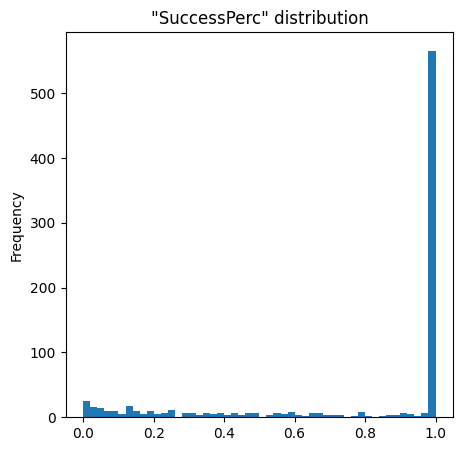

,Quantile,SuccessPerc
0,0.01,0.003093
1,0.02,0.011087
2,0.03,0.020843
3,0.04,0.030172
4,0.05,0.043673
5,0.10,0.128144
6,0.20,0.386200
7,0.30,0.737736
8,0.40,1.000000
9,0.50,1.000000



- Dataset before filerting saved to .\Results\03a_Final_Dataset_before_filtering_and_missing.csv

- Final dataset saved to .\Results\03b_Final_Dataset.csv


In [34]:
CATEGORY_MAP='.\\Data and papers\\ICOmarks_category_map.csv'
COL_TO_KEEP=['url', 'SuccessPerc', 'ESGDummy', 'FinSentiment', 'VerifiedEmailDummy', 'StartYear', 'StartQuarter', 'StartMonth',
             'LogDurationDays',
             'RatingIcomarks', 'TeamSize', 'AdvisorSize', 'BountyDummy', 'BonusDummy', 'MVPDummy', 'Country', 'Region', 'SubRegion',
             'PreSaleDummy', 'KYCDummy', 'WhitelistDummy', 'ERC20Dummy', 'LogWhitepaperWordCount',
             'CryptoFearGreedIndex', 'CryptoFearGreedClass', 'ICORegulation',
             'ICEAIndex', 'UCRYPolicyIndex', 'UCRYPriceIndex', 'NFTsAttentionIndex', 'CBDCUncertaintyIndex', 'CBDCAttentionIndex',
             'CBECIPowerDemand', 'CBECIElectConsump', 'CBECIGreenhouseEmiss', 'CBECIHashrateShare',
             'CategoryBusinessDummy', 'CategoryEnergyDummy', 'CategoryFinanceDummy', 'CategoryInfrastructureDummy',
             'CategoryManifacturingDummy', 'CategoryOtherDummy', 'CategorySocialDummy', 'CategoryTechDummy',
            'SocialSeriesDownloaded', 'PriceSeriesDownloaded', 'FundRaisedUSD']
BINARY_CUTOFF=1  # SuccessDummy: 1 if SuccessPerc >= BINARY_CUTOFF, 0 otherwise

pd.set_option('display.max_columns', 500)
formatted_df=pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'formatted_df.pkl'))
final_df=formatted_df.merge(esg_df, on='url', how='left').merge(fin_df, on='url', how='left')

final_df[['FundHardCapUSD', 'FundSoftCapUSD']]=final_df[['FundHardCapUSD', 'FundSoftCapUSD']].replace(0, np.nan)
final_df['CapUSD'] =np.minimum(final_df['FundHardCapUSD'], final_df['FundSoftCapUSD'])
move_col = final_df.pop('CapUSD')
final_df.insert(final_df.columns.get_loc("FundSoftCapUSD")+1, 'CapUSD', move_col)
final_df['SuccessPerc']=final_df['FundRaisedUSD']/final_df['CapUSD']
final_df['SuccessPerc'].clip(lower=None, upper=1, inplace=True)
move_col = final_df.pop('SuccessPerc')
final_df.insert(final_df.columns.get_loc("CapUSD")+1, 'SuccessPerc', move_col)
final_df[['FinSentiment', 'ESGDummy']]=final_df[['FinSentiment', 'ESGDummy']].fillna(0)
# evaluate Year and Quarter of start
final_df['StartDate']=final_df['StartDate'].replace('TBA', '1 Jan 2150')
final_df['StartDate']=pd.to_datetime(final_df['StartDate'])
final_df['StartYear']=final_df['StartDate'].dt.year
final_df['StartYear']=final_df['StartYear'].replace(2150, None)
final_df['StartMonth']=final_df['StartDate'].dt.month.apply(lambda x: calendar.month_abbr[x])
final_df.loc[final_df['StartYear'].isna(), 'StartMonth']=None
final_df['StartQuarter']=final_df['StartDate'].dt.to_period('Q').astype(str)
final_df['StartQuarter']=final_df['StartQuarter'].replace('2150Q1', None)
# map Category into macro categories
categ_cols=[x for x in final_df.columns if x.startswith('Category')]
df_cat=(pd.melt(final_df[['url']+categ_cols], id_vars=['url'], value_vars=categ_cols)
 .rename(columns={'variable': 'Category'})
 .merge(pd.read_csv(CATEGORY_MAP, sep=';'), on='Category', how='left')
 .drop(columns='Category')
 .groupby(['url', 'CategoryMap'], as_index=False).sum()
 .pivot(index='url', columns='CategoryMap')['value']
)
df_cat[df_cat > 0]=1
final_df=final_df.drop(columns=categ_cols).merge(df_cat.reset_index(), on='url', how='left')
# add socials count
social_cols=[x for x in final_df.columns if x.startswith('Social')]
if 'SocialSeriesDownloaded' in social_cols:
    social_cols.remove('SocialSeriesDownloaded')
df_social=final_df[['url'] + social_cols].copy()
df_social['SocialCount']=df_social.apply(lambda x : sum([y for y in x if type(y) != str]), axis=1)
final_df=final_df.drop(columns=social_cols).merge(df_social[['url', 'SocialCount']], on='url', how='left')
# add whitepaper words count
df_text=joblib.load(os.path.join(CHECKPOINT_FOLDER, 'df_text.pkl'))
final_df=final_df.merge(df_text[['url', 'word_count']].rename(columns={'word_count': 'WhitepaperWordCount'}), on='url', how='left')
final_df['WhitepaperWordCount']=np.log10(final_df['WhitepaperWordCount'])
final_df=final_df.rename(columns={'WhitepaperWordCount': 'LogWhitepaperWordCount'})
# add Crypto Fear and Greed Index   https://alternative.me/crypto/fear-and-greed-index/
df_crypto=pd.read_csv(os.path.join(RESULTS_FOLDER, '99_Crypto_Fear_and_Greed_Index.csv'), sep=';', parse_dates=['date'])
df_crypto=df_crypto.rename(columns={'index': 'CryptoFearGreedIndex', 'classification': 'CryptoFearGreedClass'})
final_df=pd.merge_asof(final_df.sort_values(by='StartDate'), df_crypto.sort_values(by='date'),
                       left_on='StartDate', right_on='date', direction='nearest')
final_df.drop(columns=['date'], inplace=True)
# add ICO regulation    https://www.bitcoinmarketjournal.com/ico-regulations/
MANUAL_MAPPING=pd.DataFrame({'original': ['Gibraltar (UK)', 'Isle of Man(UK)', 'Hong Kong (China)', 'Macedonia', 'The United States'],
                               'new': ['Gibraltar', 'Isle of Man', 'Hong Kong', 'North Macedonia', 'United States']})
df_regulation=pd.read_csv(os.path.join('Data and papers', 'ICO Regulation by country.csv'), sep=';')
choices=list(set(final_df[~final_df.Country.isna()].Country.values))
# df_regulation[['country_final_df', 'accuracy']]=df_regulation['Country Name'].apply(lambda x: pd.Series(process.extractOne(x, choices)))
# df_regulation.query('accuracy < 100')
df_regulation['Country']=df_regulation['Country Name']
for _, row in MANUAL_MAPPING.iterrows():
    df_regulation['Country'].replace(row['original'], row['new'], inplace=True)
final_df=final_df.merge(df_regulation[['Country', 'Score']].rename(columns={'Score': 'ICORegulation'}), on='Country', how='left')
# add Crypto uncertainty index   https://sites.google.com/view/cryptocurrency-indices/home?authuser=0
file_list=['ICEA Weekly Data_Until 2022 Q4.csv', 'UCRY Weekly Data Updating_Available until 2022 Q4.csv',
           'NFTsAI weekly data updating_available 2022 Q4.csv', 'CBDC Weekly Data_Until 2022 Q4.csv']
for file in file_list:
    df=pd.read_csv(os.path.join('.\\Data and papers\\Crypto uncertainty index', file), sep=',', parse_dates=['Date'], dayfirst=True)
    df.drop(columns=['Timeline'], inplace=True)
    df.columns = df.columns.str.replace(' ', '')
    df.loc[:, df.columns != 'Date']=df.loc[:, df.columns != 'Date'] - 100
    final_df=pd.merge_asof(final_df.sort_values(by='StartDate'), df.sort_values(by='Date'),
                           left_on='StartDate', right_on='Date', direction='nearest')
    final_df.drop(columns=['Date'], inplace=True)
# add Cambridge Bitcoin Electricity Consumption Index   https://ccaf.io/cbeci/index
df=(pd.read_csv(os.path.join('.\\Data and papers\\Cambridge Bitcoin Electricity Consumption Index', 'CBECI - power demand.csv'), sep=',',
               parse_dates=['Date and Time'], skiprows=[0])
    .rename(columns={'annualised consumption GUESS, TWh': 'CBECIPowerDemand'})
    [['Date and Time', 'CBECIPowerDemand']]
   )
final_df=pd.merge_asof(final_df.sort_values(by='StartDate'), df.sort_values(by='Date and Time'),
                       left_on='StartDate', right_on='Date and Time', direction='nearest')
final_df.drop(columns=['Date and Time'], inplace=True)
df=(pd.read_csv(os.path.join('.\\Data and papers\\Cambridge Bitcoin Electricity Consumption Index', 'CBECI - electricity consumption.csv'), sep=',',
               parse_dates=['Month'], skiprows=[0])
    .rename(columns={'Monthly consumption, TWh': 'CBECIElectConsump'})
    [['Month', 'CBECIElectConsump']]
   )
final_df=pd.merge_asof(final_df.sort_values(by='StartDate'), df.sort_values(by='Month'),
                       left_on='StartDate', right_on='Month', direction='nearest')
final_df.drop(columns=['Month'], inplace=True)
df=(pd.read_csv(os.path.join('.\\Data and papers\\Cambridge Bitcoin Electricity Consumption Index', 'CBECI - greenhouse emission.csv'), sep=',',
               parse_dates=['Month'], skiprows=[0])
    .rename(columns={'Monthly emissions, MtCO2e': 'CBECIGreenhouseEmiss'})
    [['Month', 'CBECIGreenhouseEmiss']]
   )
final_df=pd.merge_asof(final_df.sort_values(by='StartDate'), df.sort_values(by='Month'),
                       left_on='StartDate', right_on='Month', direction='nearest')
final_df.drop(columns=['Month'], inplace=True)
df=(pd.read_csv(os.path.join('.\\Data and papers\\Cambridge Bitcoin Electricity Consumption Index', 'CBECI - country hashrate share.csv'), sep=',', parse_dates=['date'])
    .rename(columns={'country': 'Country_mapping', 'monthly_hashrate_%': 'CBECIHashrateShare'})
    [['date', 'Country_mapping', 'CBECIHashrateShare']]
   )
df['CBECIHashrateShare']=df['CBECIHashrateShare'].str.rstrip('%').astype('float') / 100.0
MANUAL_MAPPING=pd.DataFrame({'original': ['Mainland China', 'Russian Federation', 'Germany *', 'Ireland *'],
                               'new': ['China', 'Russia', 'Germany', 'Ireland']})
for _, row in MANUAL_MAPPING.iterrows():
    df['Country_mapping'].replace(row['original'], row['new'], inplace=True)
final_df['Country_mapping']=np.where(final_df['Country'].isin(df['Country_mapping'].unique()), final_df['Country'], 'Other')
final_df[['Country', 'Country_mapping']].drop_duplicates().sort_values(by='Country_mapping')
final_df=pd.merge_asof(final_df.sort_values(by='StartDate'), df.sort_values(by='date'),
                       left_on='StartDate', right_on='date', direction='nearest', by='Country_mapping')
final_df.drop(columns=['Country_mapping', 'date'], inplace=True) 



# save dataset before filtering and missing imputation
csv_path_missing=os.path.join(RESULTS_FOLDER, '03a_Final_Dataset_before_filtering_and_missing.csv')
final_df.to_csv(csv_path_missing, index=False, sep=';')

# select columns and filter by ICO only and SuccessPerc available
final_df=final_df[~final_df['SuccessPerc'].isna()]
final_df=final_df[(final_df['IsSTODummy'] == 0) & (final_df['IsIEODummy'] == 0)]
final_df=final_df[COL_TO_KEEP]

# fill missing with median or mode
final_df['Country'].fillna('', inplace=True)
col_to_impute=['TeamSize', 'AdvisorSize', 'LogWhitepaperWordCount', 'StartYear', 'StartQuarter', 'StartMonth', 
               'LogDurationDays', 'RatingIcomarks', 'ICORegulation']
for col in col_to_impute:
    if final_df[col].dtype == 'O':
        repl_value=final_df[col].mode()[0]
    else:    
        repl_value=final_df[col].median()
    tot_missing=final_df[col].isna().sum()
    final_df[col].fillna(repl_value, inplace=True)
    print(f'- Imputing missing with median for {col}: {tot_missing}')
if final_df.isna().sum().sum() > 0:
    print('##### NaN still present')

# show quantile of "SuccessPerc"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
final_df['SuccessPerc'].plot.hist(bins=50, ax=ax)
plt.title('"SuccessPerc" distribution')
plt.show()
quant=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4]
perc = np.quantile(final_df['SuccessPerc'], quant + [0.5] + [1-x for x in quant[::-1]])
display(pd.DataFrame({'Quantile': quant + [0.5] + [1-x for x in quant[::-1]], 'SuccessPerc': perc}))

# Set cut-off for binary target
final_df.insert(2, 'SuccessDummy', np.where(final_df['SuccessPerc'] >=  BINARY_CUTOFF, 1, 0))

csv_path=os.path.join(RESULTS_FOLDER, '03b_Final_Dataset.csv')
final_df.to_csv(csv_path, index=False, sep=';')
print('\n- Dataset before filerting saved to', csv_path_missing)
print('\n- Final dataset saved to', csv_path)

### Export Market Price and Social Users series

In [22]:
final_df=pd.read_csv(os.path.join(RESULTS_FOLDER, '03b_Final_Dataset.csv'), sep=';')
price_df=pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'ICOmarks_market_price_series.pkl'))
social_df=pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'ICOmarks_social_users_series.pkl'))

price_match=price_df[price_df['url'].isin(final_df['url'])]
social_match=social_df[social_df['url'].isin(final_df['url'])]

print(f'- Price time series matched: {price_match.url.nunique()} / {len(final_df)}')
save_path=os.path.join(RESULTS_FOLDER, '03c_ICOmarks_market_price_series_matched.csv')
price_match.to_csv(save_path, index=False, sep=';')
print(f'   - Data saved in {save_path}')

print(f'\n- Social time series matched: {social_match.url.nunique()} / {len(final_df)}')
save_path=os.path.join(RESULTS_FOLDER, '03c_ICOmarks_social_users_series_matched.csv')
social_match.to_csv(save_path, index=False, sep=';')
print(f'   - Data saved in {save_path}')

- Price time series matched: 205 / 871
   - Data saved in .\Results\03c_ICOmarks_market_price_series_matched.csv

- Social time series matched: 836 / 871
   - Data saved in .\Results\03c_ICOmarks_social_users_series_matched.csv


### Exploratory Analysis

In [20]:
EXCLUDE_VAR=['CBECIPowerDemand', 'CBECIElectConsump', 'CBECIHashrateShare', 'UCRYPriceIndex', 'NFTsAttentionIndex', 'CBDCAttentionIndex', 'SocialSeriesDownloaded', 'PriceSeriesDownloaded']

In [21]:
final_df=pd.read_csv(os.path.join(RESULTS_FOLDER, '03b_Final_Dataset.csv'), sep=';').drop(columns=['url', 'SuccessPerc'])
# final_df['SuccessDummy']=final_df['SuccessDummy'].astype(str)
final_df=final_df.rename(columns={'SuccessDummy': 'y'})
final_df=final_df.drop(columns=EXCLUDE_VAR)

# define set of numerical and categorical variables
num_var = final_df.drop(columns=['y']).select_dtypes([np.number]).columns
cat_var = final_df.drop(columns=['y']).select_dtypes(include=object).columns

final_df

,y,ESGDummy,FinSentiment,VerifiedEmailDummy,StartYear,StartQuarter,StartMonth,LogDurationDays,RatingIcomarks,TeamSize,AdvisorSize,BountyDummy,BonusDummy,MVPDummy,Country,Region,SubRegion,PreSaleDummy,KYCDummy,WhitelistDummy,ERC20Dummy,WhitepaperWordCount,CryptoFearGreedIndex,CryptoFearGreedClass,ICORegulation,ICEAIndex,UCRYPolicyIndex,CBDCUncertaintyIndex,CBECIGreenhouseEmiss,CategoryBusinessDummy,CategoryEnergyDummy,CategoryFinanceDummy,CategoryInfrastructureDummy,CategoryManifacturingDummy,CategoryOtherDummy,CategorySocialDummy,CategoryTechDummy
0,1,0.0,0.0,1,2017,2017Q2,May,1.380211,8.4,6.0,0.0,0,0,0,NaN,NaN,NaN,0,0,0,1,2821.0,30,Fear,1 - Allowed,-0.525879,-0.506723,-0.578499,0.4178,0,0,0,0,0,0,0,1
1,1,0.0,0.0,0,2017,2017Q2,Jun,1.491362,8.4,6.0,0.0,0,0,0,Russia,Europe,Eastern Europe,0,0,0,0,2821.0,30,Fear,3 - Allowed but heavily regulated,-0.413306,-0.580788,-0.517547,0.5789,0,0,1,0,0,0,0,1
2,1,1.0,0.0,0,2017,2017Q2,Jun,1.491362,8.4,5.0,0.0,0,0,0,Singapore,Asia,South-Eastern Asia,0,0,0,1,4315.0,30,Fear,3 - Allowed but heavily regulated,-0.413306,-0.580788,-0.517547,0.5789,0,0,1,0,0,0,0,0
3,0,1.0,0.0,0,2017,2017Q2,Jun,1.806180,4.9,2.0,0.0,0,0,0,United States,North America,Northern America,0,0,0,0,310.0,30,Fear,3 - Allowed but heavily regulated,-0.110766,-0.284528,-0.304218,0.5789,0,0,0,0,0,0,1,0
4,1,0.0,0.0,0,2017,2017Q3,Jul,1.556303,2.6,3.0,0.0,0,0,0,United States,North America,Northern America,0,0,0,1,2821.0,30,Fear,3 - Allowed but heavily regulated,-0.110766,-0.284528,-0.304218,0.5789,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,1,0.0,0.0,0,2018,2018Q2,May,1.662758,7.9,10.0,0.0,1,0,0,France,Europe,Western Europe,0,0,0,1,2821.0,53,Neutral,3 - Allowed but heavily regulated,5.335681,8.035437,2.469060,4.7302,0,0,1,0,0,0,0,0
867,1,0.0,0.0,0,2018,2018Q2,May,1.662758,6.1,3.0,3.0,0,0,0,NaN,NaN,NaN,0,0,0,0,2821.0,53,Neutral,1 - Allowed,5.335681,8.035437,2.469060,4.7302,0,0,0,0,0,0,1,0
868,0,0.0,0.0,0,2018,2018Q2,May,1.662758,3.7,9.0,4.0,0,0,0,NaN,NaN,NaN,0,0,0,1,2821.0,53,Neutral,1 - Allowed,5.335681,8.035437,2.469060,4.7302,0,0,0,0,0,0,1,0
869,1,1.0,0.0,0,2018,2018Q2,May,1.662758,8.4,9.0,6.0,0,0,0,Cyprus,Europe,"Eastern Europe, The Middle East",1,0,0,1,803.0,53,Neutral,1 - Allowed,5.335681,8.035437,2.469060,4.7302,0,0,0,0,0,0,1,0


In [22]:
# correlation matrix
corrmat = final_df.corr()
# shape correlation matrix in key-values pairs
corrmat *= np.where(np.tri(*corrmat.shape, k=-1)==0, np.nan, 1)  # puts NaN on upper triangular matrix, including diagonal (k=-1)
corrmat_list=corrmat.unstack().to_frame()
# highlight highest correlations
corrmat_list.columns=['correlation']
corrmat_list['abs_corr']=corrmat_list.correlation.abs()
corrmat_list.sort_values(by=['abs_corr'], ascending=False, na_position='last', inplace=True)
corrmat_list.drop(columns=['abs_corr']).head(20)

C:\Users\Alessandro Bitetto\AppData\Local\Temp\ipykernel_51480\2459803270.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = final_df.corr()


correlation
ICEAIndex            UCRYPolicyIndex          0.910692
                     CBDCUncertaintyIndex     0.840415
UCRYPolicyIndex      CBDCUncertaintyIndex     0.793649
KYCDummy             WhitelistDummy           0.758504
ICEAIndex            CBECIGreenhouseEmiss     0.749556
UCRYPolicyIndex      CBECIGreenhouseEmiss     0.722162
StartYear            CBECIGreenhouseEmiss     0.589428
                     ICEAIndex                0.482176
CBDCUncertaintyIndex CBECIGreenhouseEmiss     0.453227
BountyDummy          MVPDummy                 0.384187
StartYear            UCRYPolicyIndex          0.382143
VerifiedEmailDummy   StartYear                0.346185
RatingIcomarks       BountyDummy              0.332269
                     AdvisorSize              0.314025
KYCDummy             CBDCUncertaintyIndex    -0.314011
MVPDummy             KYCDummy                 0.306589
RatingIcomarks       KYCDummy                 0.303648
                     MVPDummy                 0.291441
BountyDummy          KYCDummy                 0.289474
ESGDummy             FinSentiment             0.281644

In [23]:
# evaluate Variance Inflation Factor (VIF)
# VIF > 5 means multicollinearity

VIF_set = final_df.copy()[num_var]
cols=VIF_set.columns
VIF_set = add_constant(VIF_set.values)
pd.Series(["{0:.2f}".format(variance_inflation_factor(VIF_set, i)) for i in range(VIF_set.shape[1])], index=['constant'] + list(cols))

constant                       12573179.66
ESGDummy                              1.14
FinSentiment                          1.10
VerifiedEmailDummy                    1.18
StartYear                             2.14
LogDurationDays                       1.10
RatingIcomarks                        1.42
TeamSize                              1.14
AdvisorSize                           1.24
BountyDummy                           1.42
BonusDummy                            1.14
MVPDummy                              1.45
PreSaleDummy                          1.34
KYCDummy                              2.74
WhitelistDummy                        2.44
ERC20Dummy                            1.07
WhitepaperWordCount                   1.04
CryptoFearGreedIndex                  1.10
ICEAIndex                            11.92
UCRYPolicyIndex                       6.85
CBDCUncertaintyIndex                  5.22
CBECIGreenhouseEmiss                  3.99
CategoryBusinessDummy                 1.14
CategoryEne

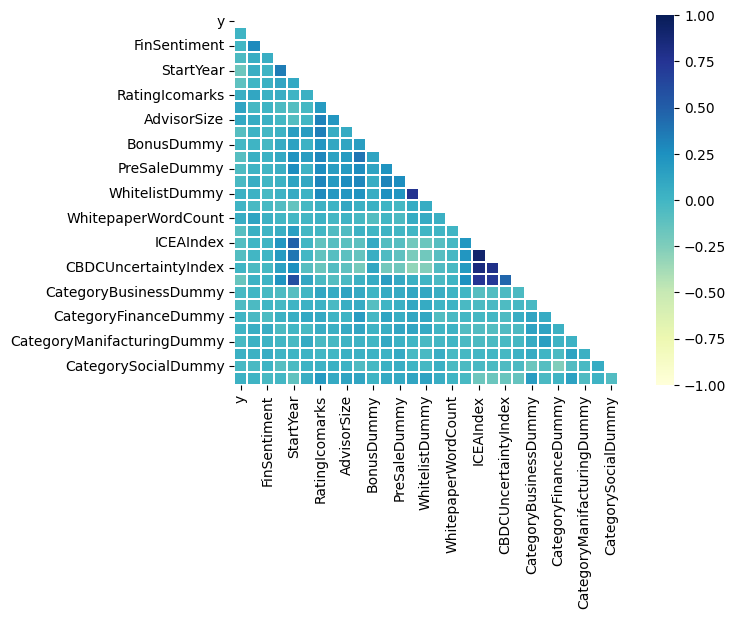

In [24]:
# plot correlation heatmap
sns.heatmap(corrmat, cmap ="YlGnBu", linewidths = 0.1, vmin = -1, vmax = 1)
plt.show()

In [314]:
# drop highly correlated columns
final_df=final_df.drop(columns=['WhitelistDummy'])

# update set of numerical and categorical variables
num_var = final_df.drop(columns=['y']).select_dtypes([np.number]).columns
cat_var = final_df.drop(columns=['y']).select_dtypes(include=object).columns

<Figure size 1000x3000 with 0 Axes>

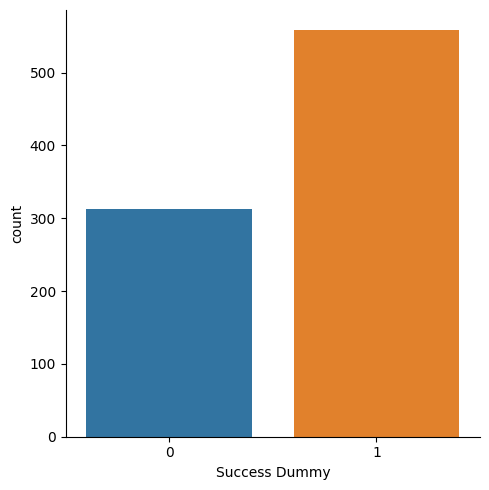

In [25]:
# check distribution for target variable

plt.figure(figsize=(10,30))
sns.catplot(x='y', kind="count", data=final_df)
plt.xlabel('Success Dummy')
plt.savefig('.\\Latex_Table_Figure\\Target_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

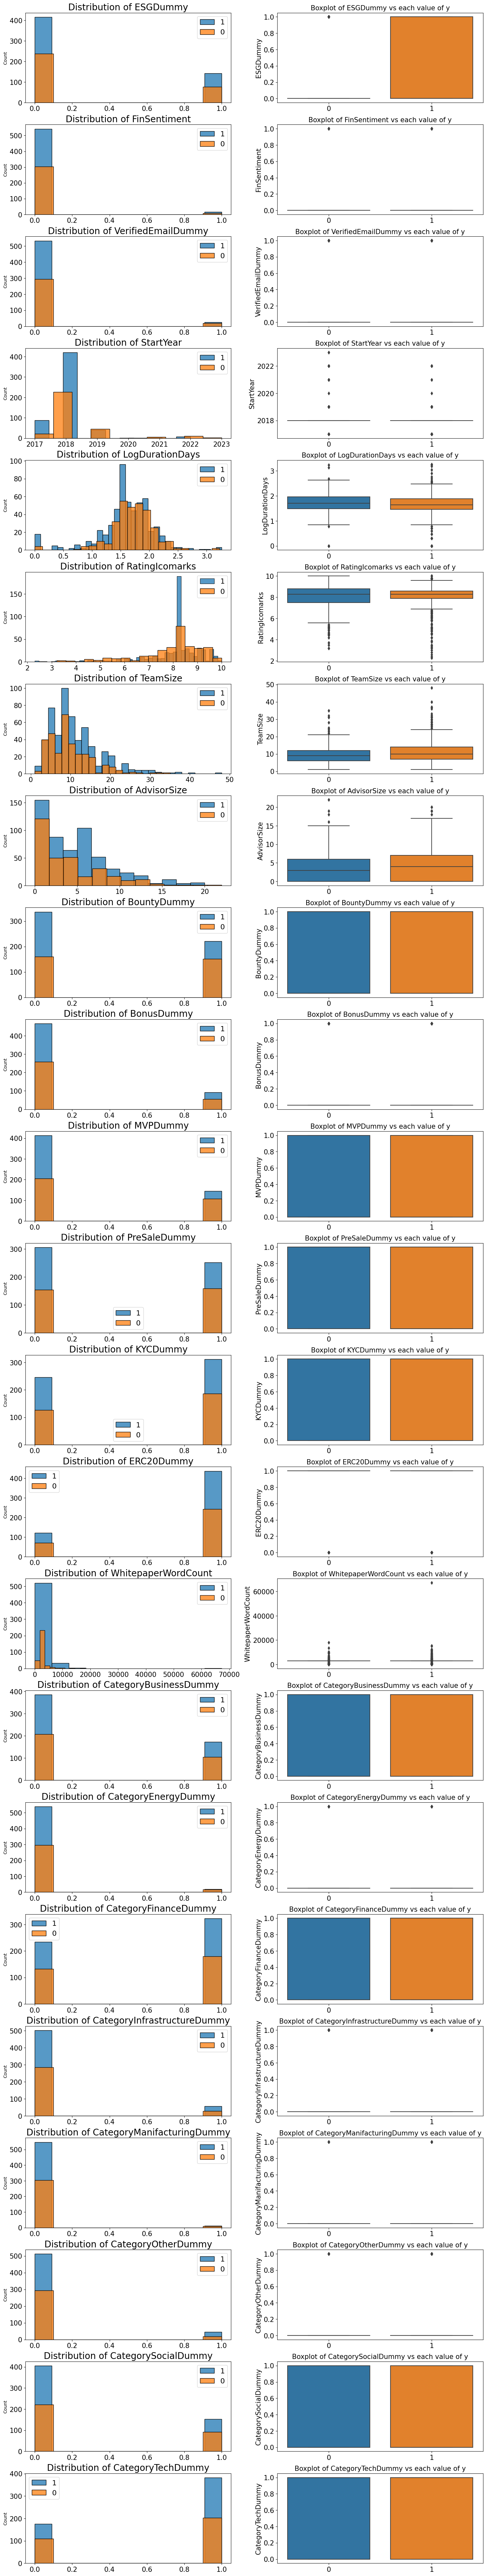

In [316]:
# plot numerical variables distribution compared to target (it's only 0 or 1)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,80), constrained_layout=True)
spec = gridspec.GridSpec(nrows=len(num_var),ncols=2, figure=fig)  # allows to use grid location for subplots
plot_count=1

# scale variable for better visualizing boxplot
# final_df=pd.DataFrame(preprocessing.StandardScaler().fit_transform(dataset[num_var].values),columns = num_var)
# dataset_scaled['y']=dataset['y'].astype(str)

for var_index, var in enumerate(num_var):

    # plot variable distribution 
    ax_left = fig.add_subplot(spec[var_index, 0])
    y_1 = final_df.loc[final_df['y'] == 1]
    y_0 = final_df.loc[final_df['y'] == 0]
    sns.histplot(y_1[var], label='1', ax=ax_left, kde_kws={'bw': 1.5})
    sns.histplot(y_0[var], label='0', ax=ax_left, kde_kws={'bw': 1.5})
    ax_left.set_title('Distribution of ' + var, fontsize=20)
    ax_left.tick_params(labelsize=15)
    ax_left.set_xlabel('')
    ax_left.legend(fontsize=16)
    plot_count += 1
    
    # plot boxplot for variable against target
    ax_right = fig.add_subplot(spec[var_index, 1])
    ax_right=sns.boxplot(x='y', y=var, data=final_df)
    ax_right.set_title('Boxplot of ' + var + ' vs each value of y', fontsize=15)
    ax_right.tick_params(labelsize=15)
    ax_right.set_xlabel('')
    ax_right.set_ylabel(var, fontsize=15)

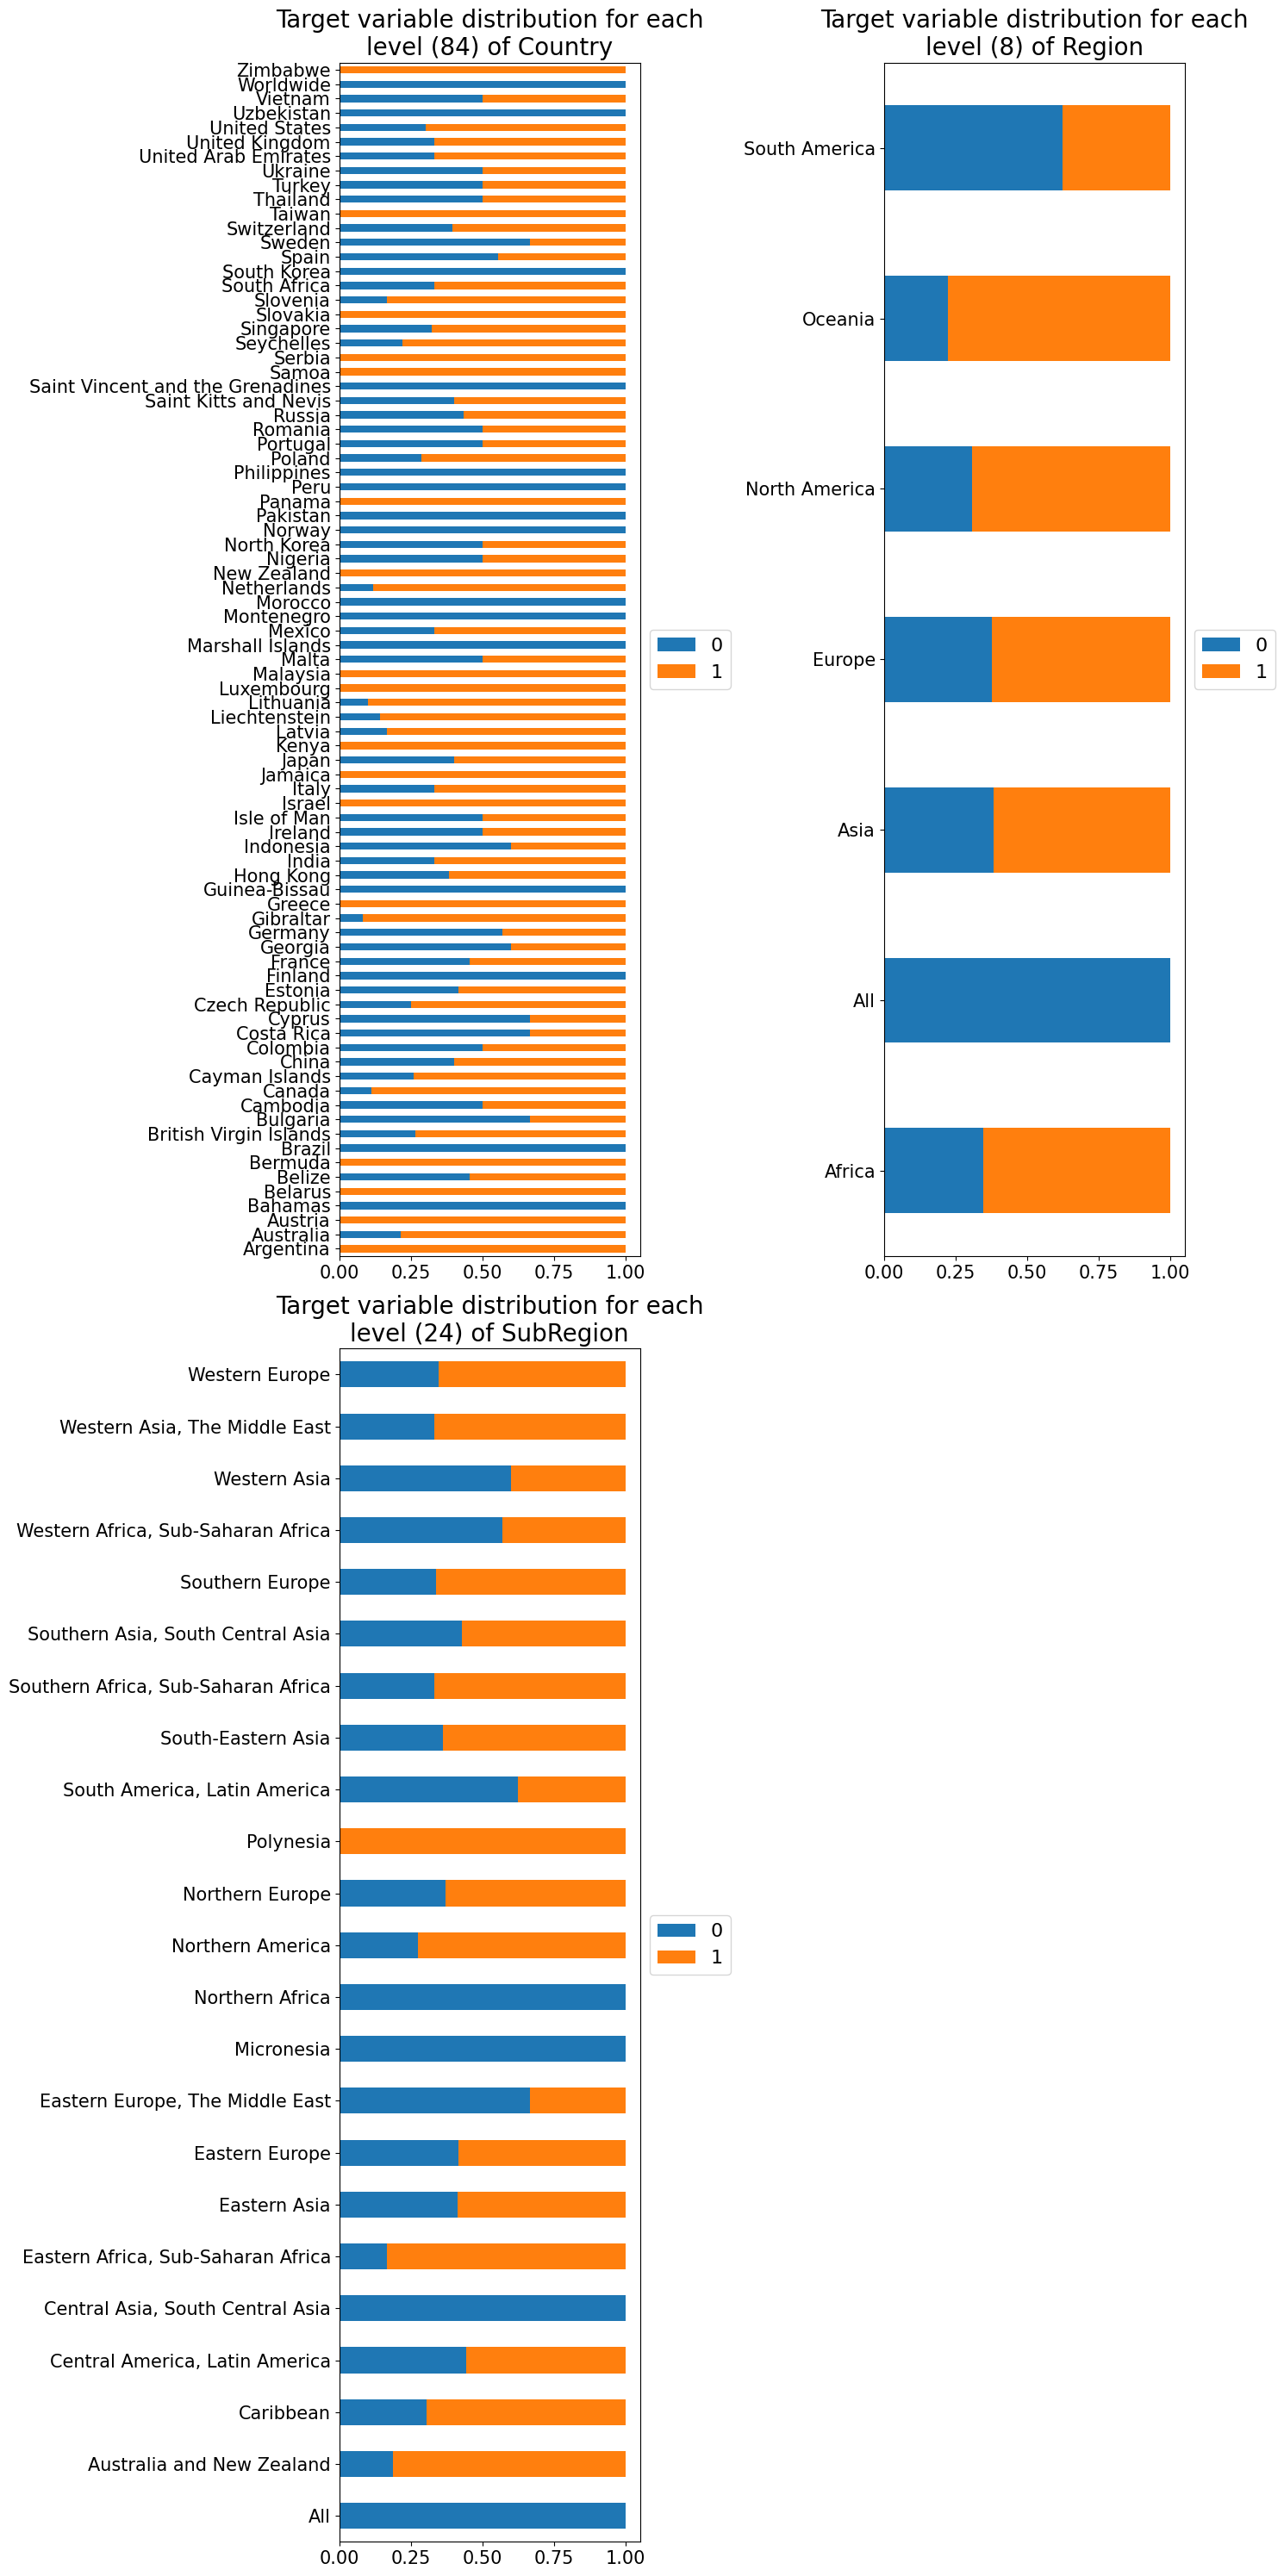

In [317]:
# for categorical variables we cannot plot the box plot but we can inspect how their levels (each string value) are distributed

fig = plt.figure(figsize=(15,30))
plot_count=1

for var in cat_var:
    
    # plot variable distribution 
    ax = fig.add_subplot(math.ceil(len(cat_var) / 2), 2, plot_count)
    plot_set = final_df.groupby([var, 'y']).size().reset_index().pivot(columns='y', index=var, values=0)
    plot_set = plot_set.div(plot_set.sum(axis=1), axis=0).plot(kind='barh', stacked=True, ax=ax)
    ax.set_title('Target variable distribution for each\nlevel (' + str(len(final_df[var].unique())) +
                 ') of ' + var, fontsize=20)
    ax.tick_params(labelsize=15)
    ax.set_ylabel('')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16)
    plot_count += 1
plt.tight_layout()
plt.show()

In [29]:
final_df.groupby(['y', 'ESGDummy']).size()

y  ESGDummy
0  0.0         237
   1.0          76
1  0.0         416
   1.0         142
dtype: int64

In [71]:
mapping

,country,region,subregion
0,Algeria,Africa,Northern Africa
1,Angola,Africa,"Middle Africa, Sub-Saharan Africa"
2,Benin,Africa,"Western Africa, Sub-Saharan Africa"
3,Botswana,Africa,"Southern Africa, Sub-Saharan Africa"
4,Burkina Faso,Africa,"Western Africa, Sub-Saharan Africa"
...,...,...,...
229,Paraguay,South America,"South America, Latin America"
230,Peru,South America,"South America, Latin America"
231,Suriname,South America,"South America, Latin America"
232,Uruguay,South America,"South America, Latin America"


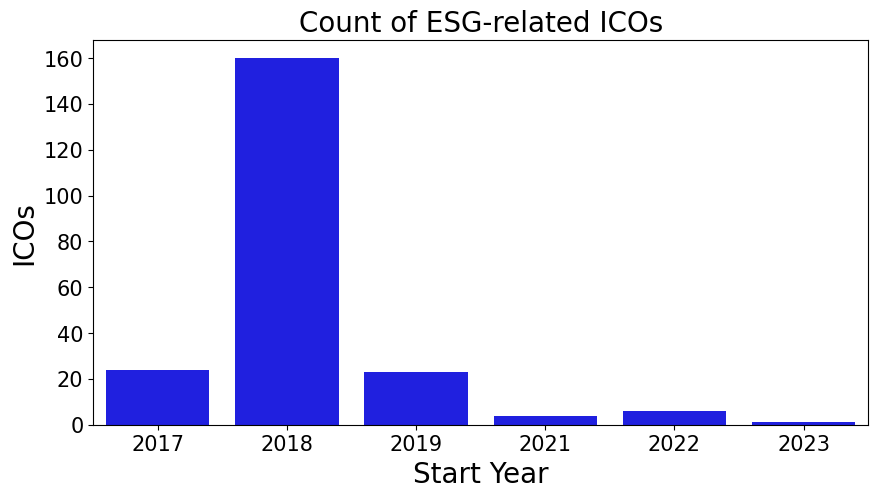

In [56]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plot_data=final_df[final_df['ESGDummy'] == 1].groupby('StartYear', as_index=False).size().rename(columns={'size': 'ICOs'})
plot_data['StartYear']=plot_data['StartYear'].astype(int).astype(str)
sns.barplot(data=plot_data, x='StartYear', y='ICOs', ax=ax, color='blue')
ax.set_title('Count of ESG-related ICOs', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Start Year', fontsize=20)
ax.set_ylabel('ICOs', fontsize=20)
fig.savefig('.\\Latex_Table_Figure\\ESG_over_years.png', bbox_inches='tight', dpi=300)

<Axes: xlabel='y', ylabel='size'>

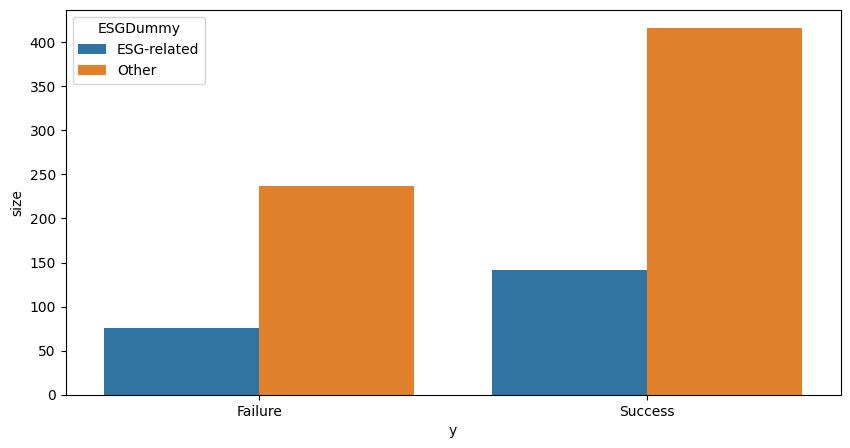

In [67]:
plot_data=final_df.copy()
plot_data['y']=np.where(plot_data['y']==1, 'Success', 'Failure')
plot_data['ESGDummy']=np.where(plot_data['ESGDummy']== 1 ,'ESG-related', 'Other')
plot_data=plot_data.groupby(['y','ESGDummy'], as_index=False).size()
plot_data
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.barplot(data=plot_data, x='y', y='size', ax=ax, hue='ESGDummy')

In [13]:
ind=[9, 12, 39, 44, 48, 54, 153, 181]
formatted_df.iloc[ind][['Ticker', 'ICOPrice', 'PriceUSD']]

,Ticker,ICOPrice,PriceUSD
9,XSR,"1 ETH = 5,000 XSR",0.352117
12,LX,"1 ETH = 15,000 LX",0.117372
39,P8,0.01 USD,0.010000
44,REW,1 REW = 0.01 EUR,0.011599
48,TAI,1 ETH = 150 TAI,2.519197
54,VSL,1 ETH = 1364 VSL,1.712728
153,VTX,1 VTX = 0.33$,0.330000
181,FET,≈ 0.085 USD,0.085000


In [3]:
formatted_df=pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'formatted_df.pkl'))

for i, row in formatted_df.iloc[:500].iterrows():
    
    if row['ICOPrice'] != '':
        display(pd.DataFrame(row[['Ticker', 'ICOPrice', 'PriceUSD']].values.reshape(1, -1), columns=['Ticker', 'ICOPrice', 'PriceUSD'], index=[i]))

,Ticker,ICOPrice,PriceUSD
0,SYNT,1 SYNT = 0.04 USD,0.04


,Ticker,ICOPrice,PriceUSD
1,777,"1 ETH = 17,000 [777]",0.103564


,Ticker,ICOPrice,PriceUSD
2,SONIC,1 SONIC = 0.001 ETH,1.760583


,Ticker,ICOPrice,PriceUSD
3,BOTC,1 BOTC = 2.50 USD,2.5


,Ticker,ICOPrice,PriceUSD
4,ECP,1 ECP = 0.00025 ETH,0.440146


,Ticker,ICOPrice,PriceUSD
6,HAI,1 HAI = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
7,XENC,1 XENC = 0.16 USD,0.16


,Ticker,ICOPrice,PriceUSD
8,AUTOCOIN,1 AUTOCOIN = 0.00025 ETH,0.440146


,Ticker,ICOPrice,PriceUSD
9,XSR,"1 ETH = 5,000 XSR",0.352117


,Ticker,ICOPrice,PriceUSD
10,XMK,1 XMK = 56.7 USD,56.7


,Ticker,ICOPrice,PriceUSD
11,ID,1 ID = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
12,LX,"1 ETH = 15,000 LX",0.117372


,Ticker,ICOPrice,PriceUSD
14,SVN,1 SVN = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
15,BTM,1 BTM = 0.33 USD,0.33


,Ticker,ICOPrice,PriceUSD
16,NBC,1 NBC = 0.00087 ETH,1.531707


,Ticker,ICOPrice,PriceUSD
17,mHLX,1 mHLX = 0.02 EUR,0.022499


,Ticker,ICOPrice,PriceUSD
18,ARQ,1 ARQ = 0.004545 USD,0.004545


,Ticker,ICOPrice,PriceUSD
19,AGT,1 AGT = 0.076 USD,0.076


,Ticker,ICOPrice,PriceUSD
21,DGT,1 DGT= 0.0001 ETH,0.176058


,Ticker,ICOPrice,PriceUSD
23,DEX,1 DEX = 0.00002 ETH,0.035212


,Ticker,ICOPrice,PriceUSD
24,TCO,1 TCO = 0.0042 USDT,0.004202


,Ticker,ICOPrice,PriceUSD
25,DEPH,1 DEPH = 0.025 USD,0.025


,Ticker,ICOPrice,PriceUSD
26,UTL,1 UTL = 0.00079 USD,0.00079


,Ticker,ICOPrice,PriceUSD
32,AIM,1 AIM = 0.12 USD,0.12


,Ticker,ICOPrice,PriceUSD
34,JADX,0.000018 USD = 1 JADX,0.000018


,Ticker,ICOPrice,PriceUSD
39,P8,0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
40,DR,1 USDT = 200 Doge Rush,0.005003


,Ticker,ICOPrice,PriceUSD
41,FLQ,1 BNB = 5210 FLQ,0.108783


,Ticker,ICOPrice,PriceUSD
44,REW,1 REW = 0.01 EUR,0.011599


,Ticker,ICOPrice,PriceUSD
45,ZWP,1 ZWP = 0.10 USD,0.1


,Ticker,ICOPrice,PriceUSD
46,CTM,0.0420 USD,0.042


,Ticker,ICOPrice,PriceUSD
47,BTX,0.0200 USD,0.02


,Ticker,ICOPrice,PriceUSD
48,TAI,1 ETH = 150 TAI,2.519197


,Ticker,ICOPrice,PriceUSD
49,DATx,≈ 0.0353 USD,0.0353


,Ticker,ICOPrice,PriceUSD
50,XPX,≈ 0.009 USD,0.009


,Ticker,ICOPrice,PriceUSD
51,EDR,≈ 0.27 USD,0.27


,Ticker,ICOPrice,PriceUSD
52,CTXC,≈ 0.817342 USD,0.817342


,Ticker,ICOPrice,PriceUSD
53,OCEAN,≈ 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
54,VSL,1 ETH = 1364 VSL,1.712728


,Ticker,ICOPrice,PriceUSD
56,Tiger,0.005 USD,0.005


,Ticker,ICOPrice,PriceUSD
57,DBC,1 DBC = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
58,NCH,0.00005 ETH,0.222992


,Ticker,ICOPrice,PriceUSD
59,ARTI,0.26 USD,0.26


,Ticker,ICOPrice,PriceUSD
60,GBD,0.035 USD,0.035


,Ticker,ICOPrice,PriceUSD
61,BCUBE,1 BCUBE = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
62,WRT,1 WRT = 200 USD,200.0


,Ticker,ICOPrice,PriceUSD
63,XMAP,1 XMAP = 0.0001219 ETH,0.286


,Ticker,ICOPrice,PriceUSD
64,PRM,1 PRM = 1.14 USD,1.14


,Ticker,ICOPrice,PriceUSD
65,AGI,1 AGI = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
66,MAI,1 MAI = 0.14 USD,0.14


,Ticker,ICOPrice,PriceUSD
67,FIRST,1 First = 0.0091 ETH,12.425614


,Ticker,ICOPrice,PriceUSD
68,VRX,1 VRX = 0.0167 ETH,11.296496


,Ticker,ICOPrice,PriceUSD
69,VAI,1 VAI = 0.1 EUR,0.12074


,Ticker,ICOPrice,PriceUSD
72,bDLR,1 bDLR = 0.000777 ETH,0.108139


,Ticker,ICOPrice,PriceUSD
73,SETS,1 SETS = 0.08 EUR,0.088232


,Ticker,ICOPrice,PriceUSD
75,OSP,1 OSP = 0.5 USD,0.5


,Ticker,ICOPrice,PriceUSD
78,WON,1 WON = 0.016 USD,0.016


,Ticker,ICOPrice,PriceUSD
79,NIM,1 NIM = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
83,MYC,1 MYC = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
84,NMP,1 NMP = 0.8 USD,0.8


,Ticker,ICOPrice,PriceUSD
85,CWR,1 CWR = 0.045 USD,0.045


,Ticker,ICOPrice,PriceUSD
87,HRS,1 HRS = 0.5 USD,0.5


,Ticker,ICOPrice,PriceUSD
93,ZCC,1 ZCC= 0.10 USD,0.1


,Ticker,ICOPrice,PriceUSD
94,OKS,"1 OKS = 0,001 USD",0.001


,Ticker,ICOPrice,PriceUSD
100,LEDPT,1 LEDPT = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
101,TREE,1 TREE = 0.04 USD,0.04


,Ticker,ICOPrice,PriceUSD
102,SaTT,1 SaTT = 0.0042 USD,0.0042


,Ticker,ICOPrice,PriceUSD
103,RVO,1 RVO = 0.25 USD,0.25


,Ticker,ICOPrice,PriceUSD
104,XMD,1 XMD = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
105,HRO,1 HRO = 0.1125 USD,0.1125


,Ticker,ICOPrice,PriceUSD
106,1AI,1 1AI = 0.0008 USD,0.0008


,Ticker,ICOPrice,PriceUSD
109,IPUX,1 IPUX = 4 USD,4.0


,Ticker,ICOPrice,PriceUSD
111,PCoin,"1 ETH = 8,000 PC",0.032272


,Ticker,ICOPrice,PriceUSD
112,DXB,1 DXB = 0.02 USD,0.02


,Ticker,ICOPrice,PriceUSD
113,XRX,1 XRX = 0.005 USD,0.005


,Ticker,ICOPrice,PriceUSD
114,Disticoin,1 Disticoin = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
116,R2R,1 R2R = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
120,MLIV,1 MLIV = 0.008 USD,0.008


,Ticker,ICOPrice,PriceUSD
122,TAL,1 TAL = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
125,VRH,1 VRH = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
127,WSE,1 WSE = 10 USD,10.0


,Ticker,ICOPrice,PriceUSD
128,XAI,1 XAI = 0.8 USD,0.8


,Ticker,ICOPrice,PriceUSD
129,MoCo,1 MoCo = 0.018 USD,0.018


,Ticker,ICOPrice,PriceUSD
132,ORX,1 ORX = 0.055 USD,0.055


,Ticker,ICOPrice,PriceUSD
133,AIB,1 AIB = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
134,24Car,1 24Car = 0.0001 ETH,0.012024


,Ticker,ICOPrice,PriceUSD
135,Sesame Token / SST,1 Sesame Token / SST = 0.001 USD,0.001


,Ticker,ICOPrice,PriceUSD
138,Dbto1,1 Dbto1 = 0.01 ETH,1.518158


,Ticker,ICOPrice,PriceUSD
139,KTS,1 KTS = 0.01 ETH,2.544613


,Ticker,ICOPrice,PriceUSD
141,MIG,1 MIG = 0.2 USD,0.2


,Ticker,ICOPrice,PriceUSD
142,XR,1 XR = 0.15 USD,0.15


,Ticker,ICOPrice,PriceUSD
143,AIPBS,1 AIPBS = 0.001 ETH,0.151816


,Ticker,ICOPrice,PriceUSD
146,BTSMD,1 BTSMD = 0.9 BTS,0.055006


,Ticker,ICOPrice,PriceUSD
147,XYUS,1 XYUS = 0.25 USD,0.25


,Ticker,ICOPrice,PriceUSD
148,NBLR,1 NBLR = 0.08 USD,0.08


,Ticker,ICOPrice,PriceUSD
150,XAMM,1 XAMM = 0.095 USD,0.095


,Ticker,ICOPrice,PriceUSD
151,KIKI,1 KIKI = 0.005 USD,0.005


,Ticker,ICOPrice,PriceUSD
152,HXC,1 HXC = 0.11 USD,0.11


,Ticker,ICOPrice,PriceUSD
153,VTX,1 VTX = 0.33$,0.33


,Ticker,ICOPrice,PriceUSD
154,ENCN,1 ENCN = 0.24 USD,0.24


,Ticker,ICOPrice,PriceUSD
156,CBR,"1 ETH = 4,500 CBR",0.047845


,Ticker,ICOPrice,PriceUSD
157,CLRTY,1 CLRTY = 1 ETH,155.35421


,Ticker,ICOPrice,PriceUSD
158,SHKG,"1 ETH = 2,500 SHKG",0.048096


,Ticker,ICOPrice,PriceUSD
159,BIR,1 BIR = 0.2 USD,0.2


,Ticker,ICOPrice,PriceUSD
160,XRMT,1 XRMT = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
161,ARCX,1 ARCX = 0.15 USD,0.15


,Ticker,ICOPrice,PriceUSD
162,DSLA,1 DSLA = 0.0000040 ETH,0.000621


,Ticker,ICOPrice,PriceUSD
163,SWI,0.6000 USD,0.6


,Ticker,ICOPrice,PriceUSD
164,SBA,0.0239 USD,0.0239


,Ticker,ICOPrice,PriceUSD
165,EPR,1 EPR = 0.0000153846 ETH,0.001898


,Ticker,ICOPrice,PriceUSD
166,OCEAN,1 OCEAN = 0.192 EUR,0.217248


,Ticker,ICOPrice,PriceUSD
167,OXY2,1 OXY2 = 0.000625 ETH,0.07515


,Ticker,ICOPrice,PriceUSD
169,VTUUR,1 VTUUR = 0.25 USD,0.25


,Ticker,ICOPrice,PriceUSD
170,MHP,1 MHP = 0.08 USD,0.08


,Ticker,ICOPrice,PriceUSD
171,OSC,1 OSC = 0.00006 ETH,0.009321


,Ticker,ICOPrice,PriceUSD
172,PXC,1 PXC = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
173,CIX100,0.6544 USD,0.6544


,Ticker,ICOPrice,PriceUSD
175,WPT,0.2000 USD,0.2


,Ticker,ICOPrice,PriceUSD
176,PRY,1 PRY = 0.10 USD,0.1


,Ticker,ICOPrice,PriceUSD
177,Bright,1 Bright = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
178,PLAZA,0.0444 USD,0.0444


,Ticker,ICOPrice,PriceUSD
179,SOCM,0.1133 USD,0.1133


,Ticker,ICOPrice,PriceUSD
180,PLTX,1 PLTX = 0.15 USD,0.15


,Ticker,ICOPrice,PriceUSD
181,FET,≈ 0.085 USD,0.085


,Ticker,ICOPrice,PriceUSD
183,INFLR,1 INFLR = 0.00025 ETH,0.089609


,Ticker,ICOPrice,PriceUSD
184,CCX Token,0.0900 USD,0.09


,Ticker,ICOPrice,PriceUSD
185,TGC,1 TGC = 0.06 USD,0.06


,Ticker,ICOPrice,PriceUSD
187,USAT,1 USAT = 0.00095133 USD,0.000951


,Ticker,ICOPrice,PriceUSD
188,WORK,1 WORK = 0.000025 ETH,0.005383


,Ticker,ICOPrice,PriceUSD
189,NAi,1.3000 USD,1.3


,Ticker,ICOPrice,PriceUSD
190,AXL,0.1300 USD,0.13


,Ticker,ICOPrice,PriceUSD
191,LAX,1 LAX = 0.035 USD,0.035


,Ticker,ICOPrice,PriceUSD
192,HLX,1 HLX = 0.00016 ETH,0.034448


,Ticker,ICOPrice,PriceUSD
193,TZO,1 TZO = 0.06 USD,0.06


,Ticker,ICOPrice,PriceUSD
196,ZMC,1 ZMC = 0.25 USD,0.25


,Ticker,ICOPrice,PriceUSD
197,CargoCoin,1.0000 USD,1.0


,Ticker,ICOPrice,PriceUSD
198,GBTC,1 GBTC = 0.248 USD,0.248


,Ticker,ICOPrice,PriceUSD
199,TCHN,1 TCHN = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
200,YEZ,1 YEZ = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
201,NRM,0.0360 USD,0.036


,Ticker,ICOPrice,PriceUSD
202,4ART,1 4ART = 0.30 EUR,0.35073


,Ticker,ICOPrice,PriceUSD
203,NEW,≈ 0.0037 USD,0.0037


,Ticker,ICOPrice,PriceUSD
204,UPZ,1 UPZ = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
205,E2C,≈ 0.5 USD,0.5


,Ticker,ICOPrice,PriceUSD
206,ViV,266.9500 USD,266.95


,Ticker,ICOPrice,PriceUSD
207,AIUR,1 AIUR = 0.01 ETH,5.16926


,Ticker,ICOPrice,PriceUSD
208,BNR,1 BNR = 0.0001 ETH,0.062623


,Ticker,ICOPrice,PriceUSD
209,SRT,1 SRT = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
210,SPIKE,0.0100 USD,0.01


,Ticker,ICOPrice,PriceUSD
211,RCALLS,1 RCALL = 0.0000001 ETH,0.000022


,Ticker,ICOPrice,PriceUSD
212,WAY,1 WAY = 0.14 USD,0.14


,Ticker,ICOPrice,PriceUSD
214,SG,1 SG = 100 USD,100.0


,Ticker,ICOPrice,PriceUSD
215,AIPAY,1 AIPAY = 0.00000005 ETH,0.000008


,Ticker,ICOPrice,PriceUSD
216,OPU,0.0200 USD,0.02


,Ticker,ICOPrice,PriceUSD
217,SKYM,0.2000 USD,0.2


,Ticker,ICOPrice,PriceUSD
218,NRS,1 NRS = 0.0001 ETH,0.015535


,Ticker,ICOPrice,PriceUSD
219,TAL,1 TAL = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
220,SRV,"1 ETH = 60,000 SRV",0.004303


,Ticker,ICOPrice,PriceUSD
222,AIRT,0.8000 USD,0.8


,Ticker,ICOPrice,PriceUSD
223,NWP,1 NWP = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
224,ALC Token,0.5000 USD,0.5


,Ticker,ICOPrice,PriceUSD
225,AQX,AQX = 0.18 USD,0.18


,Ticker,ICOPrice,PriceUSD
226,PARK,1 PARK = 0.5 USD,0.5


,Ticker,ICOPrice,PriceUSD
227,BOSE,1 BOSE = 0.25 USD,0.25


,Ticker,ICOPrice,PriceUSD
228,XCLP,1 XCLP = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
229,YOU,1 YOU = 0.01 EUR,0.011599


,Ticker,ICOPrice,PriceUSD
230,IBO,"1 ETH = 7,000 IBO",0.063508


,Ticker,ICOPrice,PriceUSD
231,RNDIT,1 RNDIT = 10 EUR,11.599


,Ticker,ICOPrice,PriceUSD
232,ALUX,0.2000 USD,0.2


,Ticker,ICOPrice,PriceUSD
233,STAR,"1 ETH = 1,000 STAR",0.258172


,Ticker,ICOPrice,PriceUSD
234,FBC,0.0900 USD,0.09


,Ticker,ICOPrice,PriceUSD
235,AER,1 AER = 0.00035 ETH,0.09036


,Ticker,ICOPrice,PriceUSD
236,WLME,1 WLME = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
237,DPT,0.0075 USD,0.0075


,Ticker,ICOPrice,PriceUSD
238,PGF7T,1 PGF7T = 0.30 EUR,0.33945


,Ticker,ICOPrice,PriceUSD
239,ENK,0.6299 USD,0.6299


,Ticker,ICOPrice,PriceUSD
240,BBOS,1 BBOS = 0.16 USD,0.16


,Ticker,ICOPrice,PriceUSD
241,ESTATE,0.2000 USD,0.2


,Ticker,ICOPrice,PriceUSD
242,TXP,1 TXP = 0.07 USD,0.07


,Ticker,ICOPrice,PriceUSD
243,VIVA,0.0059 USD,0.0059


,Ticker,ICOPrice,PriceUSD
244,TVS,"1 ETH = 2,000 TVS",0.129086


,Ticker,ICOPrice,PriceUSD
245,GGR,1 GGR = 0.2 USD,0.2


,Ticker,ICOPrice,PriceUSD
246,SCX,0.0720 USD,0.072


,Ticker,ICOPrice,PriceUSD
247,LDX,0.1062 USD,0.1062


,Ticker,ICOPrice,PriceUSD
248,HOARD,0.0600 USD,0.06


,Ticker,ICOPrice,PriceUSD
249,MEL,1 MEL = 0.12 USD,0.12


,Ticker,ICOPrice,PriceUSD
250,MED,1 ETH = 1500 MED,0.416036


,Ticker,ICOPrice,PriceUSD
251,CURV,1 CURV = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
252,HALA,1 HALA = 0.10 USD,0.1


,Ticker,ICOPrice,PriceUSD
253,GPX,0.1800 USD,0.18


,Ticker,ICOPrice,PriceUSD
254,DBCCoin,0.1200 USD,0.12


,Ticker,ICOPrice,PriceUSD
255,STT,1 STT = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
256,IX,1 IX = 0.0054 USD,0.0054


,Ticker,ICOPrice,PriceUSD
257,CLB,≈ 0.0158 USD,0.0158


,Ticker,ICOPrice,PriceUSD
258,CPX,1 CPX = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
259,CANA,1 CANA = 0.00014 ETH,0.036144


,Ticker,ICOPrice,PriceUSD
260,BXM,1 BXM = 1.00 USD,1.0


,Ticker,ICOPrice,PriceUSD
261,HNN,1 HNN = 0.35 USD,0.35


,Ticker,ICOPrice,PriceUSD
262,PAX,1 PAX = 1 EUR,1.1608


,Ticker,ICOPrice,PriceUSD
263,ATH,0.0500 USD,0.05


,Ticker,ICOPrice,PriceUSD
264,DFT (Delicia Food Token),0.0059 USD,0.0059


,Ticker,ICOPrice,PriceUSD
265,RCAT,1 RCAT = 0.15 USD,0.15


,Ticker,ICOPrice,PriceUSD
266,LBT,1 LBt = 0.0006 ETH,0.310156


,Ticker,ICOPrice,PriceUSD
267,TRG,0.0205 USD,0.0205


,Ticker,ICOPrice,PriceUSD
268,EVER,1 EVER = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
269,EZY,1 EZY = 0.10 CHF,0.10319


,Ticker,ICOPrice,PriceUSD
270,IAG,0.1200 USD,0.12


,Ticker,ICOPrice,PriceUSD
271,MUXE,0.0020 USD,0.002


,Ticker,ICOPrice,PriceUSD
272,XOS,1 XOS = 0.000025 ETH,0.006454


,Ticker,ICOPrice,PriceUSD
273,EMOT,"1 ETH = 28,000 EMOT",0.018462


,Ticker,ICOPrice,PriceUSD
274,WMB,0.1160 USD,0.116


,Ticker,ICOPrice,PriceUSD
275,ETT Token,0.0210 USD,0.021


,Ticker,ICOPrice,PriceUSD
276,ELAC,1 ELAC = 0.08 USD,0.08


,Ticker,ICOPrice,PriceUSD
277,BETT,1 BETT = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
278,EMI,"1 EMI = 0,1 USD",0.1


,Ticker,ICOPrice,PriceUSD
279,UBEX,≈ 0.0023 USD,0.0023


,Ticker,ICOPrice,PriceUSD
280,GBO,0.0465 USD,0.0465


,Ticker,ICOPrice,PriceUSD
281,MTA,1 MTA = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
282,BCU,1 BCU = 0.01 ETH,5.16926


,Ticker,ICOPrice,PriceUSD
284,TTN,1 TTN = 0.0002 ETH,0.088911


,Ticker,ICOPrice,PriceUSD
285,PCL,≈ 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
286,PTRT,1 ETH = 500 PTRT,1.033852


,Ticker,ICOPrice,PriceUSD
287,QRP,"1 QRP = 0,001 ETH",0.624054


,Ticker,ICOPrice,PriceUSD
288,UNC,1 UNC = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
290,ZNA,0.6000 USD,0.6


,Ticker,ICOPrice,PriceUSD
291,PAVO,1 PAVO = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
292,DIS,1 DIS = 0.11 USD,0.11


,Ticker,ICOPrice,PriceUSD
294,RLP,1 RLP = 0.0008 ETH,0.413541


,Ticker,ICOPrice,PriceUSD
295,DEVX,1 DEVX = 0.4 USD,0.4


,Ticker,ICOPrice,PriceUSD
296,CSZ,0.0153 USD,0.0153


,Ticker,ICOPrice,PriceUSD
297,BETS,0.0288 USD,0.0288


,Ticker,ICOPrice,PriceUSD
298,ZSC,1 ZSC = 0.00047 ETH,0.29433


,Ticker,ICOPrice,PriceUSD
300,DIZ,1 DIZ = 0.35 USD,0.35


,Ticker,ICOPrice,PriceUSD
301,AIOP,1 AIOP = 0.04 USD,0.04


,Ticker,ICOPrice,PriceUSD
302,SCCTN,1 SCCTN = 0.01 EUR,0.011599


,Ticker,ICOPrice,PriceUSD
304,UNG,1.5000 USD,1.5


,Ticker,ICOPrice,PriceUSD
305,UME,"1 ETH = 2,000 UME",0.222277


,Ticker,ICOPrice,PriceUSD
306,CRBK,"1 ETH = 1,330 CRBK",0.388666


,Ticker,ICOPrice,PriceUSD
307,BSCH,1 BSCH = 0.00016667 ETH,0.074094


,Ticker,ICOPrice,PriceUSD
308,DREAM,1 DREAM = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
309,Quroz,0.0294 USD,0.0294


,Ticker,ICOPrice,PriceUSD
310,ICH,0.0900 USD,0.09


,Ticker,ICOPrice,PriceUSD
311,LVA,1 LVA = 1.80 USD,1.8


,Ticker,ICOPrice,PriceUSD
312,OSA,≈ 0.06 USD,0.06


,Ticker,ICOPrice,PriceUSD
313,ZEWT,0.0500 USD,0.05


,Ticker,ICOPrice,PriceUSD
315,DRN,1 DRN = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
316,SPEC,≈ 0.0036 USD,0.0036


,Ticker,ICOPrice,PriceUSD
318,WRL,1 ETH = 4667 WRL,0.114332


,Ticker,ICOPrice,PriceUSD
319,SUP,1 SUP = 0.33 USD,0.33


,Ticker,ICOPrice,PriceUSD
320,EYE,1 EYE = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
321,CONUN,0.0600 USD,0.06


,Ticker,ICOPrice,PriceUSD
322,STR,1 STR = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
323,SAB,1 SAB = 0.50 USD,0.5


,Ticker,ICOPrice,PriceUSD
324,HQT,≈ 0.11 USD,0.11


,Ticker,ICOPrice,PriceUSD
326,InToken,1 InToken = 0.01 EUR,0.011683


,Ticker,ICOPrice,PriceUSD
327,SENNO,1.6 SENNO = 0.01 USD,0.00625


,Ticker,ICOPrice,PriceUSD
328,CZN,1 CZN = 0.60 USD,0.6


,Ticker,ICOPrice,PriceUSD
329,YON,1 YON = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
330,AIC,"1 ETH = 100,000 AIC",0.006241


,Ticker,ICOPrice,PriceUSD
331,ITR,0.4000 USD,0.4


,Ticker,ICOPrice,PriceUSD
332,GEX,1 GEX = 0.20 USD,0.2


,Ticker,ICOPrice,PriceUSD
334,SURE,1 SURE = 0.0001125 ETH,0.070206


,Ticker,ICOPrice,PriceUSD
335,SNAP,1 SNAP = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
337,AAT,1 AAT = 0.9 USD,0.9


,Ticker,ICOPrice,PriceUSD
338,AIGO,1 AIGO = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
339,OME,1 OME = 10 USD,10.0


,Ticker,ICOPrice,PriceUSD
340,WIZE,0.4000 USD,0.4


,Ticker,ICOPrice,PriceUSD
341,HEAL,0.7592 USD,0.7592


,Ticker,ICOPrice,PriceUSD
342,GANA,1 GANA = 0.025 USD,0.025


,Ticker,ICOPrice,PriceUSD
343,FTEC,0.0154 USD,0.0154


,Ticker,ICOPrice,PriceUSD
344,NTS,0.0741 USD,0.0741


,Ticker,ICOPrice,PriceUSD
345,MND,"1 ETH = 5,000 MND",0.125247


,Ticker,ICOPrice,PriceUSD
347,ECB,1 ECB = 0.63 EUR,0.768159


,Ticker,ICOPrice,PriceUSD
348,BiteCoin,1 BiteCoin = 0.01$,0.01


,Ticker,ICOPrice,PriceUSD
349,uDoo,1 uDoo = $0.08 - $0.1,0.09


,Ticker,ICOPrice,PriceUSD
350,MTT,1 MTT = 0.06 EUR,0.070098


,Ticker,ICOPrice,PriceUSD
351,EKK,1 EKK = 0.0001 ETH,0.051693


,Ticker,ICOPrice,PriceUSD
352,TCO,1 TCO = 0.3 USD,0.3


,Ticker,ICOPrice,PriceUSD
353,XRA,≈ 0.3 USD,0.3


,Ticker,ICOPrice,PriceUSD
354,SIPC,1ETH = 83333 SIPC,0.006403


,Ticker,ICOPrice,PriceUSD
355,DELTA,1 DELTA = 0.001 ETH,0.626235


,Ticker,ICOPrice,PriceUSD
356,KIMERA,1 KIMERA = 0.00036 ETH,0.192092


,Ticker,ICOPrice,PriceUSD
357,AET,"1 AET = 1,30 USD",130.0


,Ticker,ICOPrice,PriceUSD
358,CERT,0.5260 USD,0.526


,Ticker,ICOPrice,PriceUSD
359,PKX,1 PKX = 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
360,TFC,2.8750 USD,2.875


,Ticker,ICOPrice,PriceUSD
361,RBIT,1 RBIT = 0.70 USD,0.7


,Ticker,ICOPrice,PriceUSD
362,WTL,≈ 0.48 USD,0.48


,Ticker,ICOPrice,PriceUSD
363,TAR,1 TAR = 0.001 ETH,0.516926


,Ticker,ICOPrice,PriceUSD
364,ESS,≈ 0.042 USD,0.042


,Ticker,ICOPrice,PriceUSD
365,OOT,≈ 0.12 USD,0.12


,Ticker,ICOPrice,PriceUSD
366,ABL,≈ 0.053 USD,0.053


,Ticker,ICOPrice,PriceUSD
368,STC Token,1.0000 USD,1.0


,Ticker,ICOPrice,PriceUSD
369,TCOIN,1 TCOIN = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
371,JPI,1 JPI = 0.00003 ETH,0.018722


,Ticker,ICOPrice,PriceUSD
372,SFC,1 SFC = 0.00006 ETH,0.037574


,Ticker,ICOPrice,PriceUSD
373,IMT,≈ 0.005 USD,0.005


,Ticker,ICOPrice,PriceUSD
374,B2C,"1 ETH = 4,300 B2C",0.145129


,Ticker,ICOPrice,PriceUSD
375,Payo,1 Payo = 0.00002 ETH,0.010672


,Ticker,ICOPrice,PriceUSD
376,TMX,1 TMX = 0.000005 ETH,0.002668


,Ticker,ICOPrice,PriceUSD
377,DRONE,1 DRONE = 0.00005 ETH,0.031312


,Ticker,ICOPrice,PriceUSD
378,XLS,"1,000 XLM = 1,000 XLS",0.361252


,Ticker,ICOPrice,PriceUSD
380,QPS,1 QPS = 0.0013 ETH,0.693666


,Ticker,ICOPrice,PriceUSD
381,NSC,1 NSC = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
382,IPAYC,"1 ETH = 1,200 IPAY",0.444658


,Ticker,ICOPrice,PriceUSD
383,SANC,"1 ETH = 530,000 SANC",0.001007


,Ticker,ICOPrice,PriceUSD
384,DTE,1 DTE = 0.09 USD,0.09


,Ticker,ICOPrice,PriceUSD
385,ORST,0.5000 USD,0.5


,Ticker,ICOPrice,PriceUSD
387,GETX,1 GETX = 0.00065 ETH,0.641735


,Ticker,ICOPrice,PriceUSD
388,GAI,1 GAI - 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
389,FIC,0.1700 USD,0.17


,Ticker,ICOPrice,PriceUSD
390,BFP,1 BFP = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
392,BIM,"1 ETH = 130,000 BIM",0.004105


,Ticker,ICOPrice,PriceUSD
393,RELY,0.5000 USD,0.5


,Ticker,ICOPrice,PriceUSD
394,TICS,1 TICS = 0.11 USD,0.11


,Ticker,ICOPrice,PriceUSD
395,RIX,0.0069 USD,0.0069


,Ticker,ICOPrice,PriceUSD
396,BGX,1 BGX = 0.10 USD,0.1


,Ticker,ICOPrice,PriceUSD
397,BBK,1 BBK = 0.60 USD,0.6


,Ticker,ICOPrice,PriceUSD
398,OFNOG,1 OFNOG = 0.10 USD,0.1


,Ticker,ICOPrice,PriceUSD
399,HAI,1 HAI = 0.0005 ETH,0.266795


,Ticker,ICOPrice,PriceUSD
400,CR8,1 CR8 = 0.06 USD,0.06


,Ticker,ICOPrice,PriceUSD
401,DCBL,0.1500 USD,0.15


,Ticker,ICOPrice,PriceUSD
403,Kijash,0.2640 USD,0.264


,Ticker,ICOPrice,PriceUSD
404,ELI,≈ 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
405,ScudoCoin,1 SCC = 6 EUR,7.3926


,Ticker,ICOPrice,PriceUSD
406,NSD,1 NSD = 0.04 USD,0.04


,Ticker,ICOPrice,PriceUSD
407,DANK,1 DANK = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
409,iLT,1 ILT = 0.0221 USD,0.0221


,Ticker,ICOPrice,PriceUSD
410,ENLTE,1 ENLTE = 0.016 USD,0.016


,Ticker,ICOPrice,PriceUSD
411,MEDS,1 MEDS = 0.4 USD,0.4


,Ticker,ICOPrice,PriceUSD
412,UKT,0.0200 USD,0.02


,Ticker,ICOPrice,PriceUSD
413,PLMT,1 PLMT = 0.0002 ETH,0.106718


,Ticker,ICOPrice,PriceUSD
414,MRCH,"1 ETH = 10,000 MRCH",0.053359


,Ticker,ICOPrice,PriceUSD
415,OTL,1 OTL = 0.047 USD,0.047


,Ticker,ICOPrice,PriceUSD
416,SHOPIN,1 SHOPIN = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
417,ROX/ROX,0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
418,GNCT,1 GNCT = 0.30 USD,0.3


,Ticker,ICOPrice,PriceUSD
419,KSS,1 KSS = 0.30 - 0.50 USD,0.4


,Ticker,ICOPrice,PriceUSD
420,SPH,1 SPH = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
421,CADV,1 CADV = 0.001 ETH,0.533589


,Ticker,ICOPrice,PriceUSD
422,ROC,0.0933 USD,0.0933


,Ticker,ICOPrice,PriceUSD
423,YBK,1 YBK = 0.50 EUR,0.5998


,Ticker,ICOPrice,PriceUSD
424,MORPH,≈ 0.5 USD,0.5


,Ticker,ICOPrice,PriceUSD
425,CAK,1 CAK = 9 USD,9.0


,Ticker,ICOPrice,PriceUSD
426,SMRT,1 SMRT = 0.21 USD,0.21


,Ticker,ICOPrice,PriceUSD
427,KNW,1 KNW = 1.00 USD,1.0


,Ticker,ICOPrice,PriceUSD
428,AUC,≈ 0.26 USD,0.26


,Ticker,ICOPrice,PriceUSD
429,NBAI,≈ 0.0059 USD,0.0059


,Ticker,ICOPrice,PriceUSD
430,NEZ,1 NEZ = 0.30 USD,0.3


,Ticker,ICOPrice,PriceUSD
431,EHF,1 EHF = 0.01 ETH,6.262345


,Ticker,ICOPrice,PriceUSD
432,IAHC,1 IAHC = 0.0000142 ETH,0.008893


,Ticker,ICOPrice,PriceUSD
433,GSI,1 GSI = 0.002 ETH,1.974569


,Ticker,ICOPrice,PriceUSD
434,CCX,"1 ETH = 1,000 CCX",0.533589


,Ticker,ICOPrice,PriceUSD
436,NCC,≈ 0.12 USD,0.12


,Ticker,ICOPrice,PriceUSD
437,CFH,1 CFH = 0.000075 ETH,0.046968


,Ticker,ICOPrice,PriceUSD
438,C3X,1 C3X = 0.1 - 1.00 USD,0.55


,Ticker,ICOPrice,PriceUSD
440,XKN,1 XKN = 0.0002 ETH,0.106718


,Ticker,ICOPrice,PriceUSD
441,SAPIS,1.1100 USD,1.11


,Ticker,ICOPrice,PriceUSD
442,AIRE,1 ETH = 4440 AIRE,0.141044


,Ticker,ICOPrice,PriceUSD
443,SKCH,≈ 1.2 USD,1.2


,Ticker,ICOPrice,PriceUSD
444,DVR,1 DVR = 0.00005 ETH,0.031312


,Ticker,ICOPrice,PriceUSD
445,XRR,0.1 ETH = 1000 XRR,0.062623


,Ticker,ICOPrice,PriceUSD
446,WOLF,1 WOLF = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
447,AMN,≈ 0.05 USD,0.05


,Ticker,ICOPrice,PriceUSD
449,NAM,≈ 0.006 USD,0.006


,Ticker,ICOPrice,PriceUSD
450,KTM,112.0000 USD,112.0


,Ticker,ICOPrice,PriceUSD
451,G-Global Token,1 G-Global Token = 0.3 USD,0.3


,Ticker,ICOPrice,PriceUSD
452,GLC,1 ETH = 400 - 480 GLC,2.243828


,Ticker,ICOPrice,PriceUSD
453,BAS,0.0037 USD,0.0037


,Ticker,ICOPrice,PriceUSD
454,FACE,≈ 0.0349 USD,0.0349


,Ticker,ICOPrice,PriceUSD
455,EFX,≈ 0.0705 USD,0.0705


,Ticker,ICOPrice,PriceUSD
456,HCN,0.0200 USD,0.02


,Ticker,ICOPrice,PriceUSD
457,QTM,1 QTM = 0.00030ETH,0.296185


,Ticker,ICOPrice,PriceUSD
458,REF,"1 ETH = 1,600 REF",0.585646


,Ticker,ICOPrice,PriceUSD
459,SEC,"1 ETH = 30,000 SEC",0.020874


,Ticker,ICOPrice,PriceUSD
460,RCA,0.6900 USD,0.69


,Ticker,ICOPrice,PriceUSD
461,ADH,≈ 0.17 USD,0.17


,Ticker,ICOPrice,PriceUSD
462,SHC,1000 SHC = 0.25 - 0.6 ETH,0.398239


,Ticker,ICOPrice,PriceUSD
463,THT,8.333 THT = 1 USD,0.120005


,Ticker,ICOPrice,PriceUSD
464,Bizc,0.4000 USD,0.4


,Ticker,ICOPrice,PriceUSD
465,DEV,0.1215 USD,0.1215


,Ticker,ICOPrice,PriceUSD
466,SVD,≈ 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
467,OTP,1 OTP = 0.0000625 ETH,0.061705


,Ticker,ICOPrice,PriceUSD
468,HYD,1 ETH = 1000 HYD,0.937034


,Ticker,ICOPrice,PriceUSD
469,ERPCOIN,1 ERP = 0.8 USD,0.8


,Ticker,ICOPrice,PriceUSD
470,BANCA,1 BANCA = 0.002 USD,0.002


,Ticker,ICOPrice,PriceUSD
472,ZCHN,1.65$,1.65


,Ticker,ICOPrice,PriceUSD
474,LDN,1 LDN = 5 USD,5.0


,Ticker,ICOPrice,PriceUSD
475,SGP,1 SGP = 0.50 USD,0.5


,Ticker,ICOPrice,PriceUSD
476,TTC,1.5000 USD,1.5


,Ticker,ICOPrice,PriceUSD
477,MCH,0.8800 USD,0.88


,Ticker,ICOPrice,PriceUSD
478,LSTRS,0.0010 USD,0.001


,Ticker,ICOPrice,PriceUSD
479,VZT,1 VZT = 0.001 ETH,0.937034


,Ticker,ICOPrice,PriceUSD
480,VAC,1 VAC = 0.25 USD,0.25


,Ticker,ICOPrice,PriceUSD
481,BTO,1 BTO = 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
482,TKY,≈ 0.0352 USD,0.0352


,Ticker,ICOPrice,PriceUSD
483,AXP,≈ 0.1 USD,0.1


,Ticker,ICOPrice,PriceUSD
484,AXION,1 AXION = 0.001 ETH,0.342466


,Ticker,ICOPrice,PriceUSD
486,LOOK,1 LOOK = 0.01 USD,0.01


,Ticker,ICOPrice,PriceUSD
487,AOA,1 AOA = 1 USD,1.0


,Ticker,ICOPrice,PriceUSD
488,ACG,0.0300 USD,0.03


,Ticker,ICOPrice,PriceUSD
489,CODX,1 CODX = 0.067 USD,0.067


,Ticker,ICOPrice,PriceUSD
490,CATER,"1 ETH = 6,800 CATER",0.258909


,Ticker,ICOPrice,PriceUSD
493,DROP,1 DROP = 6 USD,6.0


In [7]:
robin=pd.read_csv(r'C:\Users\Alessandro Bitetto\Downloads\prices_missing.csv')
robin

,Unnamed: 0,pdfWP,url,ListDownloadedOn,NViews,VerifiedEmailDummy,IsSTODummy,IsIEODummy,Status,StartDate,...,ICO_names,urlsV1,urlV2,wplinkworking,nwords,ESG,E,S,G,openingPrice
0,2,http://docs.icon.foundation/ICON-Whitepaper-EN...,https://icomarks.com/ico/icon,06/02/2023,21446,False,False,False,Trading,2017-09-22,...,icon,https://cryptototem.com/icon-ico/,https://cryptototem.com/icon-icx-ico,1,6129,0.119,0.006,0.056,0.057,NaN
1,4,http://reports.1worldonline.com.s3.amazonaws.c...,https://icomarks.com/ico/1world,06/02/2023,20316,False,False,False,Trading,2150-01-01,...,1world,https://cryptototem.com/1world-ico/,https://cryptototem.com/1world-1wo-ico,1,7657,0.122,0.004,0.050,0.069,NaN
2,12,https://bolenum.com/whitepaper.pdf,https://icomarks.com/ico/bolenum,06/02/2023,14961,False,False,False,Trading,2017-07-15,...,bolenum,https://cryptototem.com/bolenum-ico/,https://cryptototem.com/bolenum-bln-ico,1,636,0.031,0.000,0.019,0.011,NaN
3,15,https://cdn.playkey.net/img/playkeynet/ico/Whi...,https://icomarks.com/ico/playkey,06/02/2023,16087,False,False,False,Trading,2017-11-01,...,playkey,https://cryptototem.com/playkey-ico/,https://cryptototem.com/playkey-pkt-ico,1,6802,0.114,0.004,0.058,0.052,NaN
4,27,https://cryptototem.com/wp-ico/img/files/0cmwb...,https://icomarks.com/ico/fabric-token,06/02/2023,18095,False,False,False,Trading,2018-02-15,...,fabric-token,https://cryptototem.com/fabric-token-ico/,https://cryptototem.com/fabric-token-ft-ico,1,7431,0.137,0.008,0.063,0.067,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,3085,https://request.network/assets/pdf/request_whi...,https://icomarks.com/ico/request-network,06/02/2023,17096,False,False,False,Trading,2017-10-13,...,request-network,https://cryptototem.com/request-network-ico/,https://cryptototem.com/request-network-req-ico,1,3641,0.073,0.006,0.035,0.032,NaN
254,3089,https://status.im/whitepaper.pdf,https://icomarks.com/ico/status,06/02/2023,19238,False,False,False,Trading,2017-06-20,...,status,https://cryptototem.com/status-ico/,https://cryptototem.com/status-snt-ico,1,4101,0.097,0.004,0.048,0.046,NaN
255,3090,https://suncontract.org/wp-content/uploads/202...,https://icomarks.com/ico/suncontract,06/02/2023,17044,False,False,False,Trading,2017-06-28,...,suncontract,https://cryptototem.com/suncontract-ico/,https://cryptototem.com/suncontract-snc-ico,1,2256,0.176,0.089,0.063,0.025,NaN
256,3096,https://www.jelurida.com/sites/default/files/J...,https://icomarks.com/ico/ignis,06/02/2023,17613,False,False,False,Trading,2017-08-05,...,ignis,https://cryptototem.com/ignis-ico/,https://cryptototem.com/ignis-ignis-ico,1,8933,0.116,0.008,0.030,0.078,NaN


In [4]:
price_df=pd.read_pickle(os.path.join(CHECKPOINT_FOLDER, 'ICOmarks_market_price_series.pkl'))
price_df

,url,Date,PriceUSD,MarketCap,Volume24H
0,https://icomarks.com/ico/datx,2018-03-08T07:24:21.000,0.029131,0.000000e+00,1.020410e+06
1,https://icomarks.com/ico/datx,2018-03-08T21:09:20.000,0.028205,0.000000e+00,8.314110e+05
2,https://icomarks.com/ico/datx,2018-03-09T21:09:20.000,0.025414,0.000000e+00,7.111720e+04
3,https://icomarks.com/ico/datx,2018-03-10T21:09:20.000,0.024030,0.000000e+00,6.597230e+04
4,https://icomarks.com/ico/datx,2018-03-11T21:09:20.000,0.028216,0.000000e+00,6.795210e+04
...,...,...,...,...,...
587,https://icomarks.com/ico/sophiatx,2019-10-03T21:58:06.000,0.003021,9.995285e+05,3.250656e+04
588,https://icomarks.com/ico/sophiatx,2019-10-04T21:58:05.000,0.003028,1.001997e+06,3.420829e+04
589,https://icomarks.com/ico/sophiatx,2019-10-05T21:58:05.000,0.003023,1.000350e+06,3.162786e+04
590,https://icomarks.com/ico/sophiatx,2019-10-09T21:26:05.000,0.002079,6.878067e+05,3.600827e+04


In [9]:
aa=price_df[price_df['url'].isin(robin['url'])]
aa

,url,Date,PriceUSD,MarketCap,Volume24H
0,https://icomarks.com/ico/datx,2018-03-08T07:24:21.000,0.029131,0.000000e+00,1.020410e+06
1,https://icomarks.com/ico/datx,2018-03-08T21:09:20.000,0.028205,0.000000e+00,8.314110e+05
2,https://icomarks.com/ico/datx,2018-03-09T21:09:20.000,0.025414,0.000000e+00,7.111720e+04
3,https://icomarks.com/ico/datx,2018-03-10T21:09:20.000,0.024030,0.000000e+00,6.597230e+04
4,https://icomarks.com/ico/datx,2018-03-11T21:09:20.000,0.028216,0.000000e+00,6.795210e+04
...,...,...,...,...,...
587,https://icomarks.com/ico/sophiatx,2019-10-03T21:58:06.000,0.003021,9.995285e+05,3.250656e+04
588,https://icomarks.com/ico/sophiatx,2019-10-04T21:58:05.000,0.003028,1.001997e+06,3.420829e+04
589,https://icomarks.com/ico/sophiatx,2019-10-05T21:58:05.000,0.003023,1.000350e+06,3.162786e+04
590,https://icomarks.com/ico/sophiatx,2019-10-09T21:26:05.000,0.002079,6.878067e+05,3.600827e+04


In [20]:
robin['url'].value_counts()

https://icomarks.com/ico/hyperion            3
https://icomarks.com/ico/stellargold         2
https://icomarks.com/ico/waves               2
https://icomarks.com/ico/basic-attention     2
https://icomarks.com/ico/skrumble-network    1
                                            ..
https://icomarks.com/ico/scorum              1
https://icomarks.com/ico/connectjob          1
https://icomarks.com/ico/insureum            1
https://icomarks.com/ico/gems                1
https://icomarks.com/ico/leverj              1
Name: url, Length: 253, dtype: int64

In [10]:
aa['url'].nunique()

253

In [19]:
aa.to_csv('missing_price.csv', index=False, sep=';')